This Jupyter Notebook will use data sourced from datacamp.com to analyze shots made by four players. I will be looking at the accuracy of various shots, the distribution of shots, and defensive capabilities of those four players.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('nba_players_shooting.csv')
df.head()

,INDEX,SHOOTER,X,Y,RANGE,DEFENDER,SCORE
0,0,Seth Curry,-3.808987,5.583621,"(0, 4)",Chris Paul,MADE
1,1,Seth Curry,-0.104279,5.919138,"(0, 4)",Trae Young,MADE
2,2,Seth Curry,-0.525864,8.912239,"(0, 4)",Trae Young,MADE
3,3,Seth Curry,-0.790616,7.503782,"(0, 4)",Chris Paul,MADE
4,4,Seth Curry,2.119074,5.320534,"(0, 4)",Trae Young,MADE


In [4]:
df.dtypes

INDEX         int64
SHOOTER      object
X           float64
Y           float64
RANGE        object
DEFENDER     object
SCORE        object
dtype: object

In [5]:
df.describe()

,INDEX,X,Y
count,776.000000,776.000000,776.000000
mean,387.500000,0.492154,15.400099
std,224.156196,12.934870,8.009152
min,0.000000,-24.856870,5.008911
25%,193.750000,-8.227266,8.151474
50%,387.500000,0.318647,13.665261
75%,581.250000,9.782513,21.175087
max,775.000000,24.767551,33.853913


In [6]:
df['SHOOTER'].unique()

array(['Seth Curry', 'Chris Paul', 'Russell Westbrook', 'Trae Young'],
      dtype=object)

In [7]:
df["SHOOTER"].value_counts()

SHOOTER
Trae Young           329
Chris Paul           216
Seth Curry           147
Russell Westbrook     84
Name: count, dtype: int64

In [8]:
df["RANGE"].unique()

array(['(0, 4)', '(5, 9)', '(10, 14)', '(15, 19)', '(20, 24)', '(25, 29)'],
      dtype=object)

There doesn't seem to be any missing values, and the Range is divided into 4 feet segments. A few things to note: the three point line starts at 24 feet away from the basket ( except at the corners where it's 22 feet away), and the basket starts at 4 feet away from the edge of the court. The basketball court is not symmetrical across the X and Y axis. For example, the paint is longer lengthwise than its width and corner 3's are close than threes from the arc. This means that some analysis using X and Y will be needed to determine things like accuracy from the corner or scoring in the paint. 

It looks like **X** refers to the width, i.e. corner to corner, and **Y** refers to the length of the court, i.e. from basket to basket.

<Axes: >

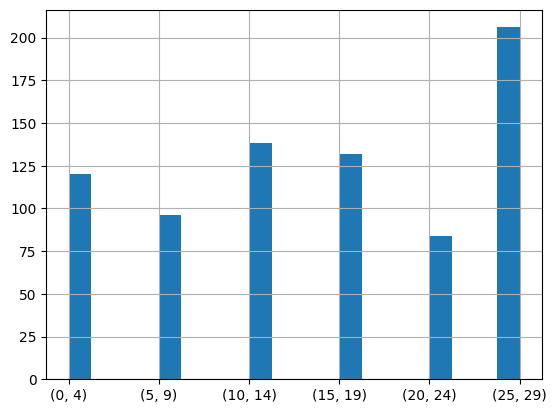

In [9]:
df["RANGE"].hist(bins=20)

In [10]:
df[df["SHOOTER"] == 'Seth Curry']["RANGE"].value_counts() / len(df[df["SHOOTER"] == 'Seth Curry']) * 100

RANGE
(25, 29)    40.136054
(20, 24)    20.408163
(15, 19)    12.244898
(0, 4)      10.884354
(5, 9)       8.163265
(10, 14)     8.163265
Name: count, dtype: float64

<Axes: >

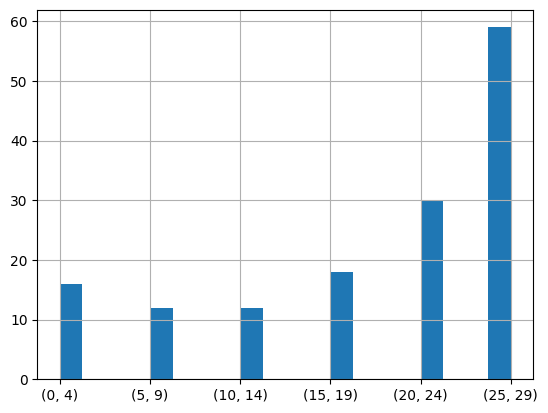

In [11]:
df[df["SHOOTER"] == 'Seth Curry']["RANGE"].hist(bins=20)

In [12]:
df[df["SHOOTER"] == 'Chris Paul']["RANGE"].value_counts() / len(df[df["SHOOTER"] == 'Chris Paul']) * 100

RANGE
(15, 19)    31.018519
(10, 14)    28.240741
(25, 29)    15.740741
(5, 9)      10.185185
(0, 4)       7.407407
(20, 24)     7.407407
Name: count, dtype: float64

<Axes: >

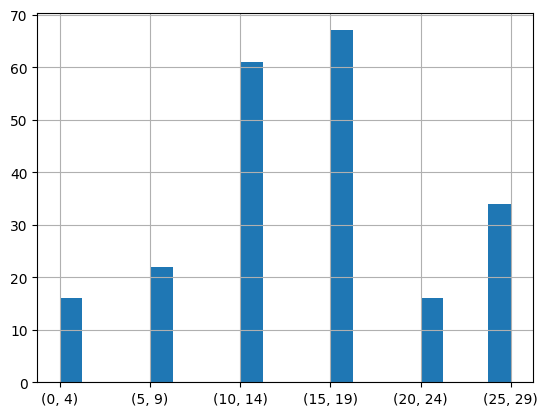

In [13]:
df[df["SHOOTER"] == 'Chris Paul']["RANGE"].hist(bins=20)

In [14]:
df[df["SHOOTER"] == 'Russell Westbrook']["RANGE"].value_counts() / len(df[df["SHOOTER"] == 'Russell Westbrook']) * 100

RANGE
(0, 4)      29.761905
(15, 19)    27.380952
(25, 29)    16.666667
(5, 9)      10.714286
(20, 24)     8.333333
(10, 14)     7.142857
Name: count, dtype: float64

<Axes: >

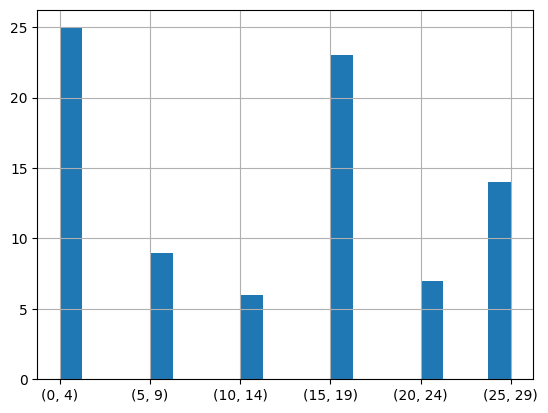

In [15]:
df[df["SHOOTER"] == 'Russell Westbrook']["RANGE"].hist(bins=20)

In [16]:
df[df["SHOOTER"] == 'Trae Young']["RANGE"].value_counts() / len(df[df["SHOOTER"] == 'Trae Young']) * 100

RANGE
(25, 29)    30.091185
(0, 4)      19.148936
(10, 14)    17.933131
(5, 9)      16.109422
(20, 24)     9.422492
(15, 19)     7.294833
Name: count, dtype: float64

<Axes: >

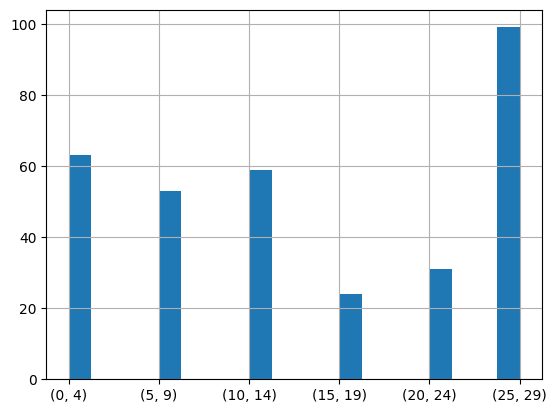

In [17]:
df[df["SHOOTER"] == 'Trae Young']["RANGE"].hist(bins=20)

Each of the four shooters present a somewhat differring style. Seth Curry specializes in long range shots, with most of his attempts being at 20 plus feet. The attempts are roughly proportional to the distance away from the basket. Chris Paul mainly shoots from midrange, in between the paint and the three point line, but doesn't take incredibly deep midrange shots. There is a spike at 25-29 feet, but there are roughly as many shots at less than 10 feet and more than 19 feet. Russell Westbrook specializes in close shots and midrange shots, with a spattering of threes. Trae Young spreads his shots out, with plenty of three pointers but plenty of close range shots and mid range shots. 

This collection of 4 players should provide many opportunities to compare and contrast their statistics. 

In [18]:
df["DEFENDER"].unique()

array(['Chris Paul', 'Trae Young', 'Russell Westbrook', 'Seth Curry'],
      dtype=object)

In [19]:
df["DEFENDER"].value_counts()

DEFENDER
Russell Westbrook    232
Chris Paul           197
Seth Curry           191
Trae Young           156
Name: count, dtype: int64

In [20]:
df["SCORE"].unique()

array(['MADE', 'MISSED'], dtype=object)

In [21]:
df[df["SHOOTER"] == "Seth Curry"]["SCORE"].value_counts()

SCORE
MADE      85
MISSED    62
Name: count, dtype: int64

In [22]:
df[df["SHOOTER"] == "Chris Paul"]["SCORE"].value_counts()

SCORE
MISSED    111
MADE      105
Name: count, dtype: int64

In [23]:
df[df["SHOOTER"] == "Russell Westbrook"]["SCORE"].value_counts()

SCORE
MISSED    56
MADE      28
Name: count, dtype: int64

In [24]:
df[df["SHOOTER"] == "Trae Young"]["SCORE"].value_counts()

SCORE
MISSED    187
MADE      142
Name: count, dtype: int64

This ends the preliminary data analysis. Now, I'll be looking at accuracy from the corner three spot, accuracy from three, midrange and from up close. Then I will look at how well each person defended against shots.

As mentioned previously, corner threes are from 22 feet above and below the basket and 14 feet across as can be seen on this diagram on the NBA's website:

*https://ak-static.cms.nba.com/wp-content/uploads/sites/4/2019/02/NBA-Court-Dimensions-.png*

I will be selecting the shots where X is plus/minus 22 feet, and Y is less than or equal to 14.

Accuracy for 3 includes corner 3's and shots from 28 feet or further.

Midrange is outside of the paint but encompassed by the 3 point line. The paint is a rectangle with dimensions: 12 by 19 feet. An easy solution will be to use the information from the shots up close and three to figure out midrange accuracy.

Close range shots are those within the paint mentioned before.

Later on the percentages for each shot type will be graphed to show the efficaciousness of each shooter.

In [25]:
Corner3df = df[abs(df.X) >= 22.0][df.Y <= 14]
Corner3df.describe()

C:\Users\Shmar\AppData\Local\Temp\ipykernel_36348\3393801247.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Corner3df = df[abs(df.X) >= 22.0][df.Y <= 14]


,INDEX,X,Y
count,54.000000,54.000000,54.000000
mean,486.370370,-4.515984,9.894997
std,255.485058,23.637168,2.161070
min,70.000000,-24.856870,5.441226
25%,320.500000,-24.232052,8.032838
50%,650.500000,-22.960338,10.255225
75%,703.500000,23.952742,11.731072
max,767.000000,23.952742,13.280662


In [26]:
Corner3df.head()

,INDEX,SHOOTER,X,Y,RANGE,DEFENDER,SCORE
70,70,Seth Curry,-22.018244,12.370524,"(20, 24)",Trae Young,MADE
91,91,Seth Curry,-24.232052,5.829153,"(25, 29)",Russell Westbrook,MADE
97,97,Seth Curry,23.952742,10.040589,"(25, 29)",Chris Paul,MADE
101,101,Seth Curry,23.952742,10.814010,"(25, 29)",Trae Young,MADE
104,104,Seth Curry,23.952742,11.105474,"(25, 29)",Trae Young,MADE


In [27]:
Corner3df['SCORE'].value_counts()

SCORE
MISSED    28
MADE      26
Name: count, dtype: int64

In [28]:
SCCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Seth Curry']

SCCorner3percent = len(SCCorner3[SCCorner3["SCORE"] == "MADE"]) / len(SCCorner3["SCORE"]) * 100

print(len(SCCorner3["SCORE"]))
SCCorner3percent

13


76.92307692307693

In [29]:
CPCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Chris Paul']

CPCorner3percent = len(CPCorner3[CPCorner3["SCORE"] == "MADE"]) / len(CPCorner3["SCORE"]) * 100

print(len(CPCorner3["SCORE"]))
CPCorner3percent

8


25.0

In [30]:
RWCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Russell Westbrook']

RWCorner3percent = len(RWCorner3[RWCorner3["SCORE"] == "MADE"]) / len(RWCorner3["SCORE"]) * 100

print(len(RWCorner3["SCORE"]))
RWCorner3percent

4


25.0

In [31]:
TYCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Trae Young']

TYCorner3percent = len(TYCorner3[TYCorner3["SCORE"] == "MADE"]) / len(TYCorner3["SCORE"]) * 100

print(len(TYCorner3["SCORE"]))
TYCorner3percent

29


44.827586206896555

Accounting for how many total shots they took, we can see that that Chris Paul and Russell Westbrook tend to not take Corner 3's and they tend to miss them. Trae Young and Seth Curry take quite a few threes from the corner and make them well. Anything at 40% or more from three is seen as good. I woukd expect Seth Curry's percentage to go down as he takes shots since 77% is sunsustainable for volume shooters. 

Next I will look at 3's not from the corner and 3's in general. The threes in general will be created by combining data from Corner 3's and from the arc.

There will need to be some experimenting with how to figure out which shots were from behind the arc and not a midrange or corner 3. It's possible that using range would work, but I may have to use the distance formula to find if they are behind the arc, i.e. more thna 24 feet away from the origin. This may also count certain corner 3's. As can be seem from the *describe* method being used, a shot can be around 24 feet away from the center and if they are on the edge of the corner 3 range then they would be definitely over 24 feet away. This means there needs to be a condition to exclude any shots that could be corner 3's. 

This means we will use the condition such that Y > 14.

In [32]:
df[df["RANGE"] == "(25, 29)"].describe()

,INDEX,X,Y
count,206.000000,206.000000,206.000000
mean,469.305825,1.313896,22.440881
std,265.783588,18.801441,8.332400
min,88.000000,-24.856870,5.441226
25%,139.250000,-17.111975,15.854462
50%,442.500000,1.714225,24.114010
75%,723.750000,21.475274,30.330252
max,775.000000,24.767551,33.853913


In [33]:
df[df["RANGE"] == "(20, 24)"].describe()

,INDEX,X,Y
count,84.000000,84.000000,84.000000
mean,366.630952,0.363457,19.407309
std,253.838284,16.365375,6.594484
min,58.000000,-23.741319,6.396797
25%,78.750000,-16.849759,13.640112
50%,324.500000,1.801137,20.957780
75%,655.250000,16.421417,24.501316
max,676.000000,23.634205,28.730485


In [42]:
import math
import numpy as np

In [44]:
df["DISTANCE"] = np.sqrt(pow(df['X'],2) + pow(df['Y'],2))
df["DISTANCE"].describe()

count    776.000000
mean      19.876875
std        8.577239
min        5.020788
25%       12.587478
50%       19.983144
75%       27.278761
max       33.915899
Name: DISTANCE, dtype: float64

In [55]:
Arc3df = df[df["DISTANCE"] >= 24][df.Y > 14]
Arc3df.describe()

C:\Users\Shmar\AppData\Local\Temp\ipykernel_36348\58249574.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Arc3df = df[df["DISTANCE"] >= 24][df.Y > 14]


,INDEX,X,Y,DISTANCE
count,222.000000,222.000000,222.000000,222.000000
mean,435.666667,2.840839,24.980420,30.223226
std,264.807292,16.041068,5.588973,2.434702
min,60.000000,-24.677397,14.053580,24.382360
25%,133.250000,-11.468424,20.472306,28.190865
50%,426.500000,3.487331,25.625726,30.789012
75%,706.500000,17.188708,29.994794,32.355804
max,775.000000,24.767551,33.853913,33.915899


In [56]:
Arc3df['SCORE'].value_counts()

SCORE
MISSED    139
MADE       83
Name: count, dtype: int64

In [57]:
SCArc3 = Arc3df[Arc3df["SHOOTER"] == 'Seth Curry']

SCArc3percent = len(SCArc3[SCArc3["SCORE"] == "MADE"]) / len(SCArc3["SCORE"]) * 100

print(len(SCArc3["SCORE"]))
SCArc3percent

68


47.05882352941176

In [58]:
CPArc3 = Arc3df[Arc3df["SHOOTER"] == 'Chris Paul']

CPArc3percent = len(CPArc3[CPArc3["SCORE"] == "MADE"]) / len(CPArc3["SCORE"]) * 100

print(len(CPArc3["SCORE"]))
CPArc3percent

42


47.61904761904761

In [59]:
RWArc3 = Arc3df[Arc3df["SHOOTER"] == 'Russell Westbrook']

RWArc3percent = len(RWArc3[RWArc3["SCORE"] == "MADE"]) / len(RWArc3["SCORE"]) * 100

print(len(RWArc3["SCORE"]))
RWArc3percent

17


23.52941176470588

In [60]:
TYArc3 = Arc3df[Arc3df["SHOOTER"] == 'Trae Young']

TYArc3percent = len(TYArc3[TYArc3["SCORE"] == "MADE"]) / len(TYArc3["SCORE"]) * 100

print(len(TYArc3["SCORE"]))
TYArc3percent

95


28.421052631578945